In [1]:

!pip install geocoder
!pip install folium
print('installed')

     |████████████████████████████████| 98 kB 8.9 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 7.0 MB/s  eta 0:00:01
installed


In [3]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [5]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [6]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [7]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [8]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M5H\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [9]:

df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [10]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [11]:

def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [12]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M5H\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [13]:

print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [14]:

def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [15]:
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [16]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [17]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [18]:

df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae,43.76944,-79.23892
6,M1J\n,Scarborough\n,Scarborough Village,43.74446,-79.23117
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496


In [20]:
address = 'Scarborough,Toronto'

# geolocator = Nominatim()
# location = geolocator.geocode(address)
latitude_x = 43.773077
longitude_y = -79.257774
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


In [21]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [23]:

address = 'Scarborough,Toronto'

latitude_n1 = 43.773077
longitude_n1 = -79.257774
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [24]:
CLIENT_ID = 'JRV5SLYEHPQ3ZNXVIMDVHTLJBFMIG0PKD31F5ALULIYIU22F' # your Foursquare ID
CLIENT_SECRET = 'ODESIIY4SIGVBGA4CKDTDJBZM2X4XLM12QMHDF0U03LDH41L' # your Foursquare Secret
ACCESS_TOKEN = 'YR5AUG4D3WFQL5LKV3BCDOHJWVMMTLW4VL3DWGUYAMPSHQDA' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JRV5SLYEHPQ3ZNXVIMDVHTLJBFMIG0PKD31F5ALULIYIU22F
CLIENT_SECRET:ODESIIY4SIGVBGA4CKDTDJBZM2X4XLM12QMHDF0U03LDH41L


In [25]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [26]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [27]:

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
3,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
4,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334


In [29]:

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
3,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
4,American Eagle Store,Clothing Store,43.776012,-79.258334


In [30]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      8
Restaurant          5
Coffee Shop         4
Department Store    2
Sandwich Place      2
Pharmacy            2
Gas Station         2
Intersection        2
Tea Room            1
Gym                 1
Name: categories, dtype: int64

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods
Don Mills
Don Mills
Not assigned

Not assigned

Bathurst Manor, Wilson Heights, Downsview North
No

In [33]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 306 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,22,22,22,22,22,22
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",15,15,15,15,15,15
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25


In [34]:
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,T

In [35]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.09
1                Bank  0.05
2                Café  0.05
3  Chinese Restaurant  0.05
4                Park  0.05


---- Alderwood, Long Branch ----
         venue  freq
0          Pub  0.12
1         Pool  0.12
2  Gas Station  0.12
3          Gym  0.12
4  Coffee Shop  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
               venue  freq
0        Pizza Place  0.13
1               Park  0.13
2        Coffee Shop  0.13
3     Sandwich Place  0.07
4  Mobile Phone Shop  0.07


---- Bayview Village ----
              venue  freq
0           Dog Run  0.17
1              Park  0.17
2             Trail  0.17
3  Asian Restaurant  0.17
4       Gas Station  0.17


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.08
1      Sandwich Place  0.08
2  Italian Restaurant  0.08
3     Thai Restaurant  0.08
4             Butcher  0.04


---- Berczy Park ----
       

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)


In [38]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pizza Place,Department Store,Breakfast Spot,Skating Rink,Supermarket,Café,Sushi Restaurant,Latin American Restaurant,Sandwich Place
1,"Alderwood, Long Branch",Pool,Pub,Sandwich Place,Pizza Place,Coffee Shop,Gas Station,Gym,Pharmacy,Donut Shop,Distribution Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Park,Coffee Shop,Mediterranean Restaurant,Restaurant,Fried Chicken Joint,Sandwich Place,Intersection,Deli / Bodega,Sushi Restaurant
3,Bayview Village,Flower Shop,Asian Restaurant,Park,Trail,Gas Station,Dog Run,Farmers Market,Farm,Falafel Restaurant,Event Space
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Thai Restaurant,Coffee Shop,Italian Restaurant,Comfort Food Restaurant,Intersection,Fast Food Restaurant,Pizza Place,Sports Club,Liquor Store


In [39]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2], dtype=int32)

In [40]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,1,Hotel,Coffee Shop,Café,Restaurant,Beer Bar,Seafood Restaurant,Japanese Restaurant,Pizza Place,Arts & Crafts Store,Bookstore
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662,0,Zoo Exhibit,Construction & Landscaping,Fast Food Restaurant,Paintball Field,Convenience Store,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Fish & Chips Shop,History Museum,Bar,Yoga Studio,Event Space,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470,2,Park,Gymnastics Gym,Athletics & Sports,Gym / Fitness Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761,2,Park,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [41]:
kclusters = 10

In [42]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [48]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [50]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"][0:103],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [51]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

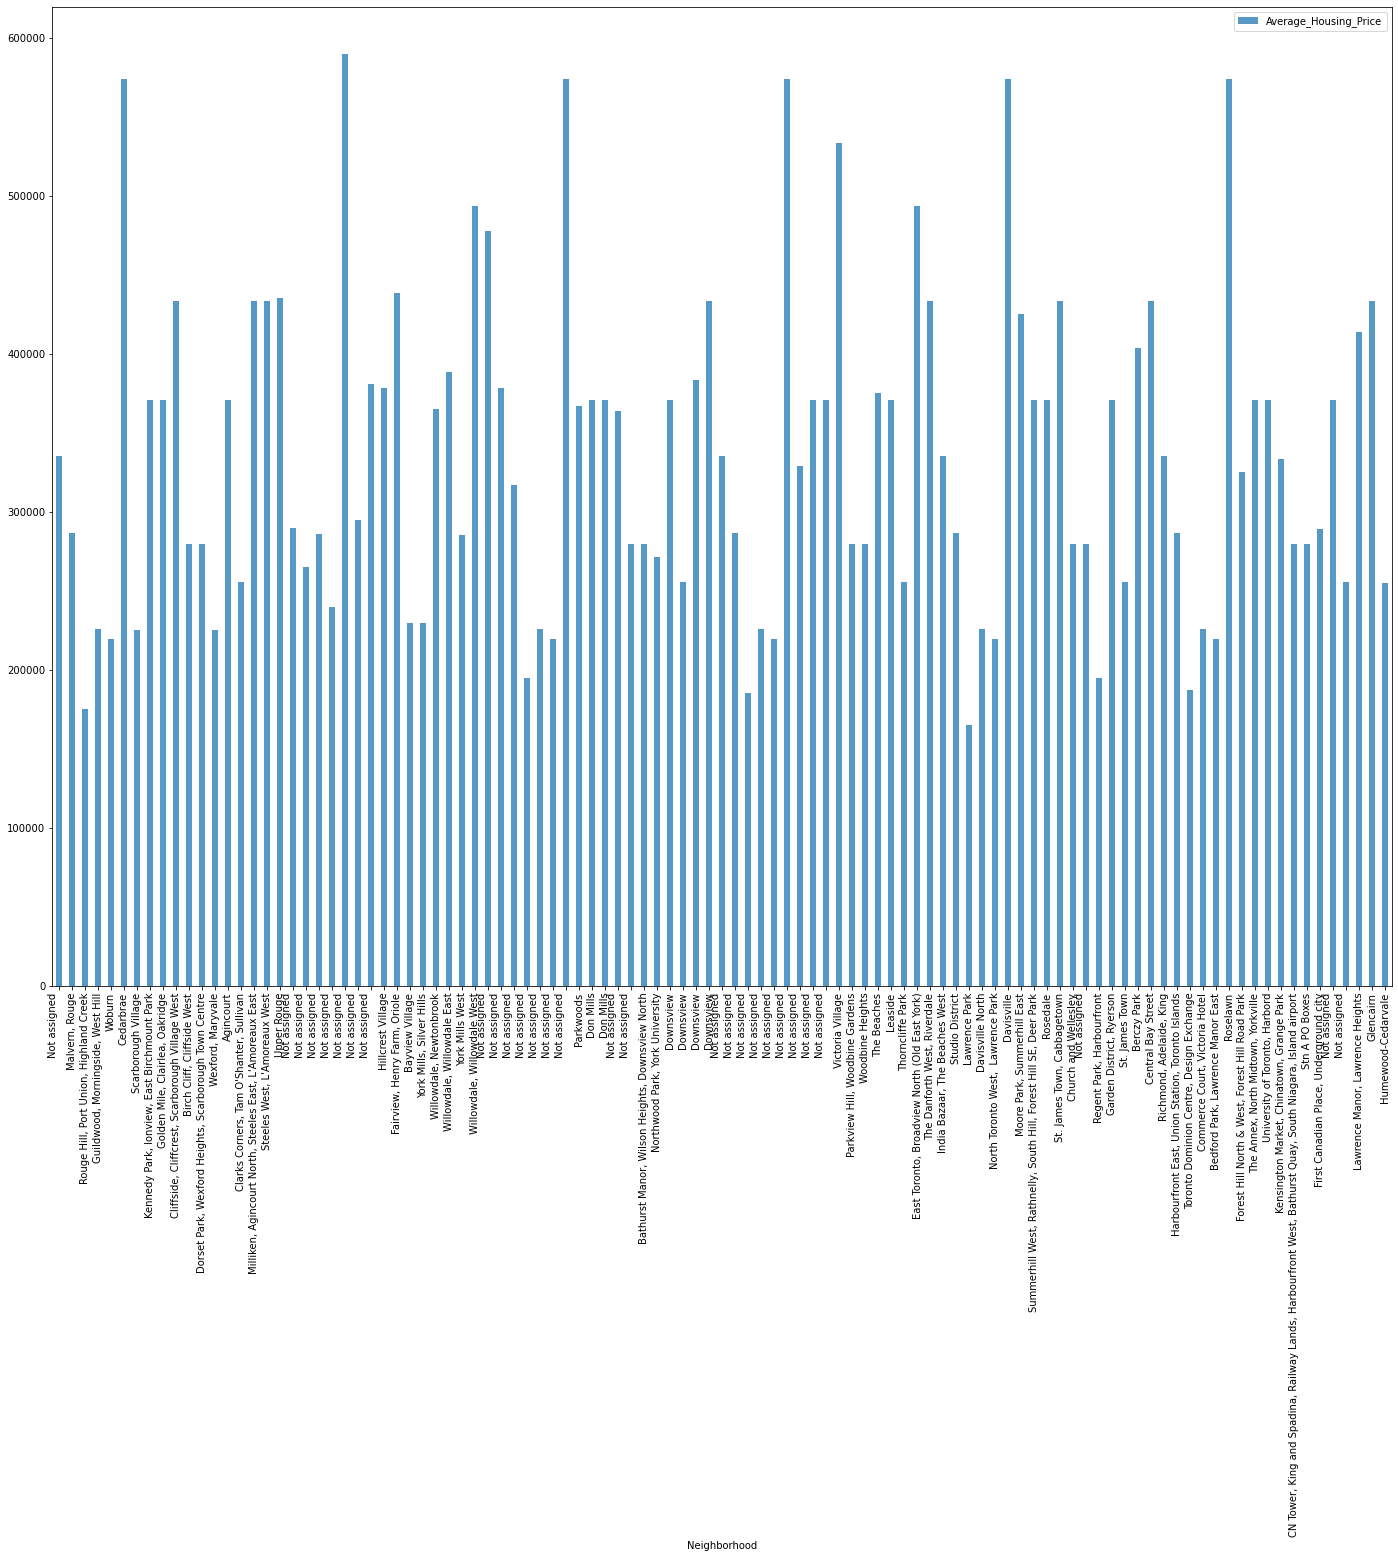

In [52]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [53]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [54]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"][0:103],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [55]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

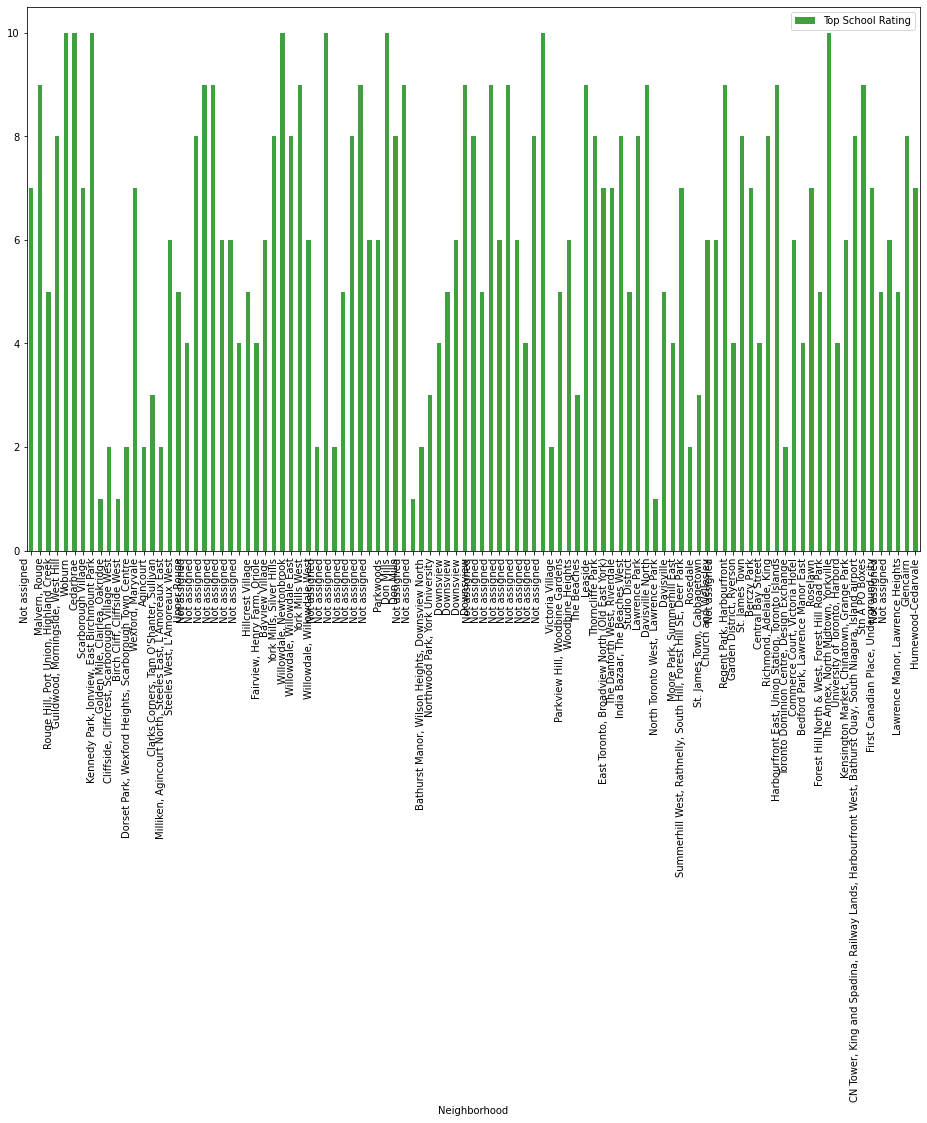

In [56]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.

Namastey, Thank You! Hope You Liked My Work, I'm Still Learning!
